In [1]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
width = 50
height = 25
plt.rcParams['figure.figsize'] = [width, height]

In [4]:
model_name = 'gpt2'
#model_name = 'gpt2-xl'
#model_name = "EleutherAI/gpt-neo-1.3B"
#model_name = "EleutherAI/gpt-neo-2.7B"
#model_name = "EleutherAI/gpt-j-6B"             # This one is too big

device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [5]:
max_length = 150


input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""

input_txt = """In a shocking finding, scientist discovered 
a herd of unicorns living in a remote, previously unexplored 
valley, in the Andes Mountains. Even more surprising to the 
researchers was the fact that the unicorns spoke perfect English.
"""


In [6]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [7]:
len(input_ids[0])

56

In [8]:
output = model.generate(input_ids, 
                        max_length=max_length, 
                        do_sample=False)
print(tokenizer.decode(output[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered 
a herd of unicorns living in a remote, previously unexplored 
valley, in the Andes Mountains. Even more surprising to the 
researchers was the fact that the unicorns spoke perfect English.

"The unicorns were so well-behaved that they were able to communicate with each other in a way that was

not possible with other animals," said Dr. David L. Smith, a professor of anthropology at the University of California, Santa Barbara.

"They were able to communicate with each other in a way that was not possible with other animals," said Dr. Smith, who was not involved in the study.

The researchers found


In [9]:
def runit(model, input_ids, n_steps=34, choices_per_step=15):

    its=[]
    with torch.no_grad():
        for _ in tqdm(range(n_steps), desc="Running..."):
            iteration = dict()
            iteration["Input"] = tokenizer.decode(input_ids[0])
            output = model(input_ids=input_ids)
        
            # Select logits of the first batch and the last token and apply softmax to get the probability
            next_token_logits = output.logits[0, -1, :]
            next_token_probs = torch.softmax(next_token_logits, dim=-1)
            sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        
            # Store tokens with highest probabilities in our little table
            for choice_idx in range(choices_per_step):
                token_id = sorted_ids[choice_idx]
                token_prob = next_token_probs[token_id].cpu().numpy()
                token_choice = (
                    f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
                )
                iteration[f"Choice {choice_idx+1}"] = token_choice
                iteration[f"Prob {choice_idx+1}"] = token_prob
            its.append(iteration)

            
            # Append predicted next token to input
            input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
    return its, input_ids

In [10]:
iterations, input_ids = runit(model, input_ids, n_steps=105)

Running...: 100%|██████████| 105/105 [00:00<00:00, 106.62it/s]


In [11]:
len(input_ids[0]), len(iterations)

(161, 105)

In [12]:
#its, input_ids = runit(model, input_ids)
#iterations += its

In [13]:
#len(input_ids[0]), len(iterations)

In [14]:
#its, input_ids = runit(model, input_ids)
#iterations += its

In [15]:
#len(input_ids[0]), len(iterations)

In [16]:
df = pd.DataFrame(iterations)
df

,Input,Choice 1,Prob 1,Choice 2,Prob 2,Choice 3,Prob 3,Choice 4,Prob 4,Choice 5,...,Choice 11,Prob 11,Choice 12,Prob 12,Choice 13,Prob 13,Choice 14,Prob 14,Choice 15,Prob 15
0,"In a shocking finding, scientist discovered \n...",\n (97.39%),0.97394663,The (0.32%),0.0031712216,""" (0.17%)",0.0017420731,' (0.08%),0.0008307729,In (0.08%),...,And (0.03%),0.00032140894,So (0.03%),0.00026579647,They (0.02%),0.00023734313,He (0.02%),0.00020897252,What (0.02%),0.00019422066
1,"In a shocking finding, scientist discovered \n...",""" (22.08%)",0.22075652,The (16.25%),0.16247663,In (3.40%),0.03402215,They (3.14%),0.03139461,According (2.32%),...,And (0.97%),0.009685832,Their (0.90%),0.00904225,Scientists (0.87%),0.008695383,While (0.79%),0.007936649,Researchers (0.77%),0.0076583247
2,"In a shocking finding, scientist discovered \n...",The (12.58%),0.12579377,They (12.06%),0.12061618,It (8.25%),0.08247805,We (7.73%),0.07728731,I (6.03%),...,If (1.42%),0.014154646,A (1.38%),0.013775371,What (1.16%),0.01164134,Their (1.15%),0.011545637,Our (1.15%),0.011520295
3,"In a shocking finding, scientist discovered \n...",unic (23.41%),0.2341102,unicorn (2.83%),0.028259434,researchers (2.28%),0.022767808,(1.96%),0.019609267,study (1.34%),...,language (0.62%),0.006208437,team (0.59%),0.005939519,people (0.55%),0.005494415,most (0.47%),0.0047208243,discovery (0.45%),0.004465156
4,"In a shocking finding, scientist discovered \n...",orns (98.99%),0.98994875,orn (0.85%),0.0085218465,urs (0.05%),0.0005088479,ur (0.00%),4.9212547e-05,or (0.00%),...,od (0.00%),1.8377217e-05,opes (0.00%),1.834276e-05,ore (0.00%),1.8307459e-05,oras (0.00%),1.788521e-05,urn (0.00%),1.7377115e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,"In a shocking finding, scientist discovered \n...",to (99.09%),0.9909355,", (0.13%)",0.0012551787,use (0.04%),0.000388196,""" (0.03%)",0.00034913607,talk (0.03%),...,learn (0.02%),0.00016705274,tell (0.01%),0.00014677933,and (0.01%),0.00011766011,communicate (0.01%),0.00010830264,make (0.01%),0.000100577076
101,"In a shocking finding, scientist discovered \n...",communicate (34.41%),0.34410778,speak (5.20%),0.051976286,learn (3.73%),0.03729145,use (2.37%),0.023713112,talk (1.52%),...,hear (0.76%),0.0075885397,form (0.74%),0.007435237,recognize (0.63%),0.0063364482,walk (0.62%),0.0062395437,live (0.62%),0.0062367837
102,"In a shocking finding, scientist discovered \n...",with (55.07%),0.5507163,in (8.26%),0.082572974,using (3.00%),0.030044995,by (2.70%),0.027044173,through (2.47%),...,easily (0.70%),0.007007206,to (0.66%),0.006568263,only (0.65%),0.006521376,on (0.57%),0.0057443026,and (0.57%),0.0056996434
103,"In a shocking finding, scientist discovered \n...",each (76.51%),0.76513636,one (6.82%),0.0681755,their (2.88%),0.02884707,the (2.72%),0.027203303,other (1.41%),...,themselves (0.21%),0.0020561474,every (0.19%),0.0018848991,an (0.19%),0.0018524514,all (0.17%),0.0017471479,others (0.16%),0.0016008774


In [17]:
print(df['Input'].iloc[-1])

In a shocking finding, scientist discovered 
a herd of unicorns living in a remote, previously unexplored 
valley, in the Andes Mountains. Even more surprising to the 
researchers was the fact that the unicorns spoke perfect English.

"The unicorns were so well-behaved that they were able to communicate with each other in a way that was

not possible with other animals," said Dr. David L. Smith, a professor of anthropology at the University of California, Santa Barbara.

"They were able to communicate with each other in a way that was not possible with other animals," said Dr. Smith, who was not involved in the study.

The researchers found that the unicorns were able to communicate with each


In [18]:
probsdf = df.filter(like='Prob').astype(float)
probsdf

,Prob 1,Prob 2,Prob 3,Prob 4,Prob 5,Prob 6,Prob 7,Prob 8,Prob 9,Prob 10,Prob 11,Prob 12,Prob 13,Prob 14,Prob 15
0,0.973947,0.003171,0.001742,0.000831,0.000818,0.000770,0.000637,0.000635,0.000610,0.000368,0.000321,0.000266,0.000237,0.000209,0.000194
1,0.220757,0.162477,0.034022,0.031395,0.023193,0.017755,0.015990,0.015385,0.013100,0.011889,0.009686,0.009042,0.008695,0.007937,0.007658
2,0.125794,0.120616,0.082478,0.077287,0.060341,0.059925,0.022336,0.021567,0.019265,0.017147,0.014155,0.013775,0.011641,0.011546,0.011520
3,0.234110,0.028259,0.022768,0.019609,0.013396,0.012738,0.009578,0.008834,0.008487,0.007577,0.006208,0.005940,0.005494,0.004721,0.004465
4,0.989949,0.008522,0.000509,0.000049,0.000035,0.000025,0.000024,0.000020,0.000019,0.000019,0.000018,0.000018,0.000018,0.000018,0.000017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,0.990936,0.001255,0.000388,0.000349,0.000328,0.000272,0.000248,0.000239,0.000223,0.000194,0.000167,0.000147,0.000118,0.000108,0.000101
101,0.344108,0.051976,0.037291,0.023713,0.015216,0.012366,0.012005,0.011875,0.011047,0.009416,0.007589,0.007435,0.006336,0.006240,0.006237
102,0.550716,0.082573,0.030045,0.027044,0.024691,0.013774,0.010188,0.008674,0.008299,0.007458,0.007007,0.006568,0.006521,0.005744,0.005700
103,0.765136,0.068176,0.028847,0.027203,0.014064,0.010882,0.008670,0.004573,0.003097,0.002670,0.002056,0.001885,0.001852,0.001747,0.001601


<AxesSubplot:>

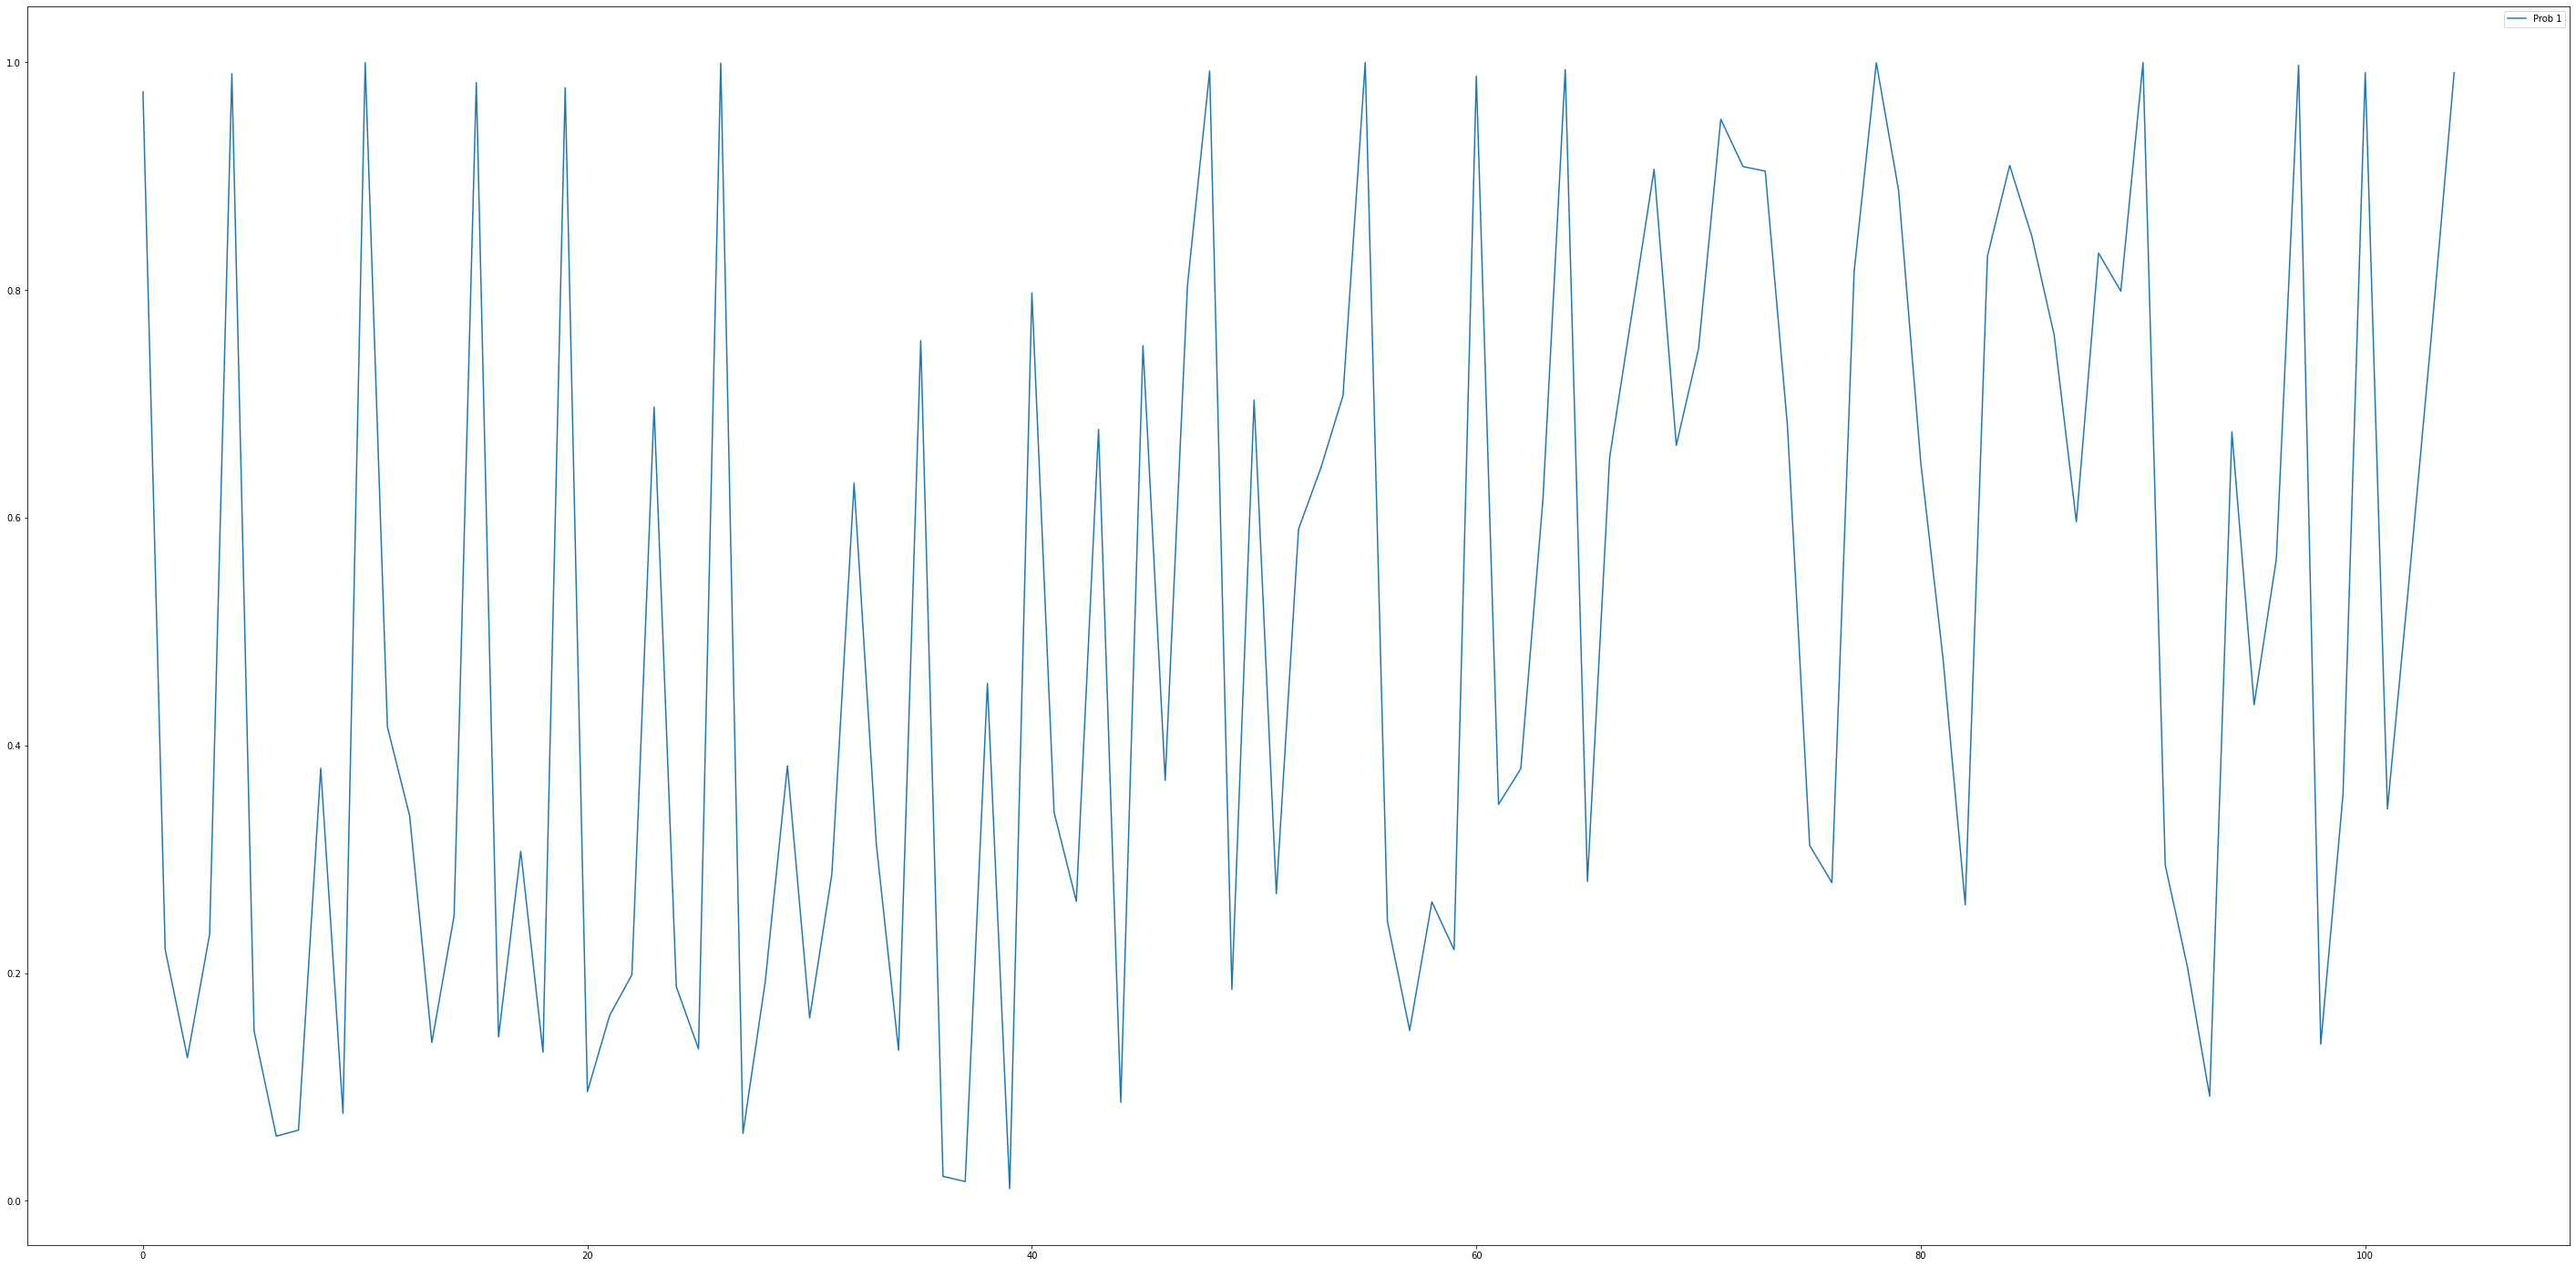

In [19]:
probsdf.plot.line(y='Prob 1')

In [20]:
probsdf.T

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
Prob 1,0.973947,0.220757,0.125794,0.234110,0.989949,0.149279,0.056824,0.062155,0.379980,0.076890,...,0.435736,0.563702,0.997458,0.137667,0.356923,0.990936,0.344108,0.550716,0.765136,0.990872
Prob 2,0.003171,0.162477,0.120616,0.028259,0.008522,0.104390,0.054375,0.030578,0.066180,0.069817,...,0.055469,0.028174,0.002325,0.069702,0.031721,0.001255,0.051976,0.082573,0.068176,0.003521
Prob 3,0.001742,0.034022,0.082478,0.022768,0.000509,0.033485,0.036760,0.023754,0.066144,0.069325,...,0.029662,0.022952,0.000111,0.065554,0.029206,0.000388,0.037291,0.030045,0.028847,0.002434
Prob 4,0.000831,0.031395,0.077287,0.019609,0.000049,0.030355,0.027060,0.020256,0.045417,0.037065,...,0.020138,0.020819,0.000004,0.051571,0.026959,0.000349,0.023713,0.027044,0.027203,0.001148
Prob 5,0.000818,0.023193,0.060341,0.013396,0.000035,0.027111,0.017077,0.018208,0.037198,0.036190,...,0.016454,0.005338,0.000004,0.047877,0.019175,0.000328,0.015216,0.024691,0.014064,0.000373
Prob 6,0.000770,0.017755,0.059925,0.012738,0.000025,0.025794,0.016207,0.017396,0.031903,0.030176,...,0.014247,0.005269,0.000003,0.034432,0.013781,0.000272,0.012366,0.013774,0.010882,0.000310
Prob 7,0.000637,0.015990,0.022336,0.009578,0.000024,0.023435,0.014489,0.016027,0.015822,0.029819,...,0.013890,0.004472,0.000003,0.032339,0.010765,0.000248,0.012005,0.010188,0.008670,0.000221
Prob 8,0.000635,0.015385,0.021567,0.008834,0.000020,0.019955,0.014319,0.015509,0.015479,0.029066,...,0.012273,0.004097,0.000003,0.028089,0.010418,0.000239,0.011875,0.008674,0.004573,0.000203
Prob 9,0.000610,0.013100,0.019265,0.008487,0.000019,0.019010,0.012820,0.015431,0.014698,0.024359,...,0.010902,0.004091,0.000003,0.026590,0.009132,0.000223,0.011047,0.008299,0.003097,0.000106
Prob 10,0.000368,0.011889,0.017147,0.007577,0.000019,0.014329,0.012351,0.012302,0.013510,0.022693,...,0.010069,0.003643,0.000002,0.018254,0.009040,0.000194,0.009416,0.007458,0.002670,0.000081


<AxesSubplot:>

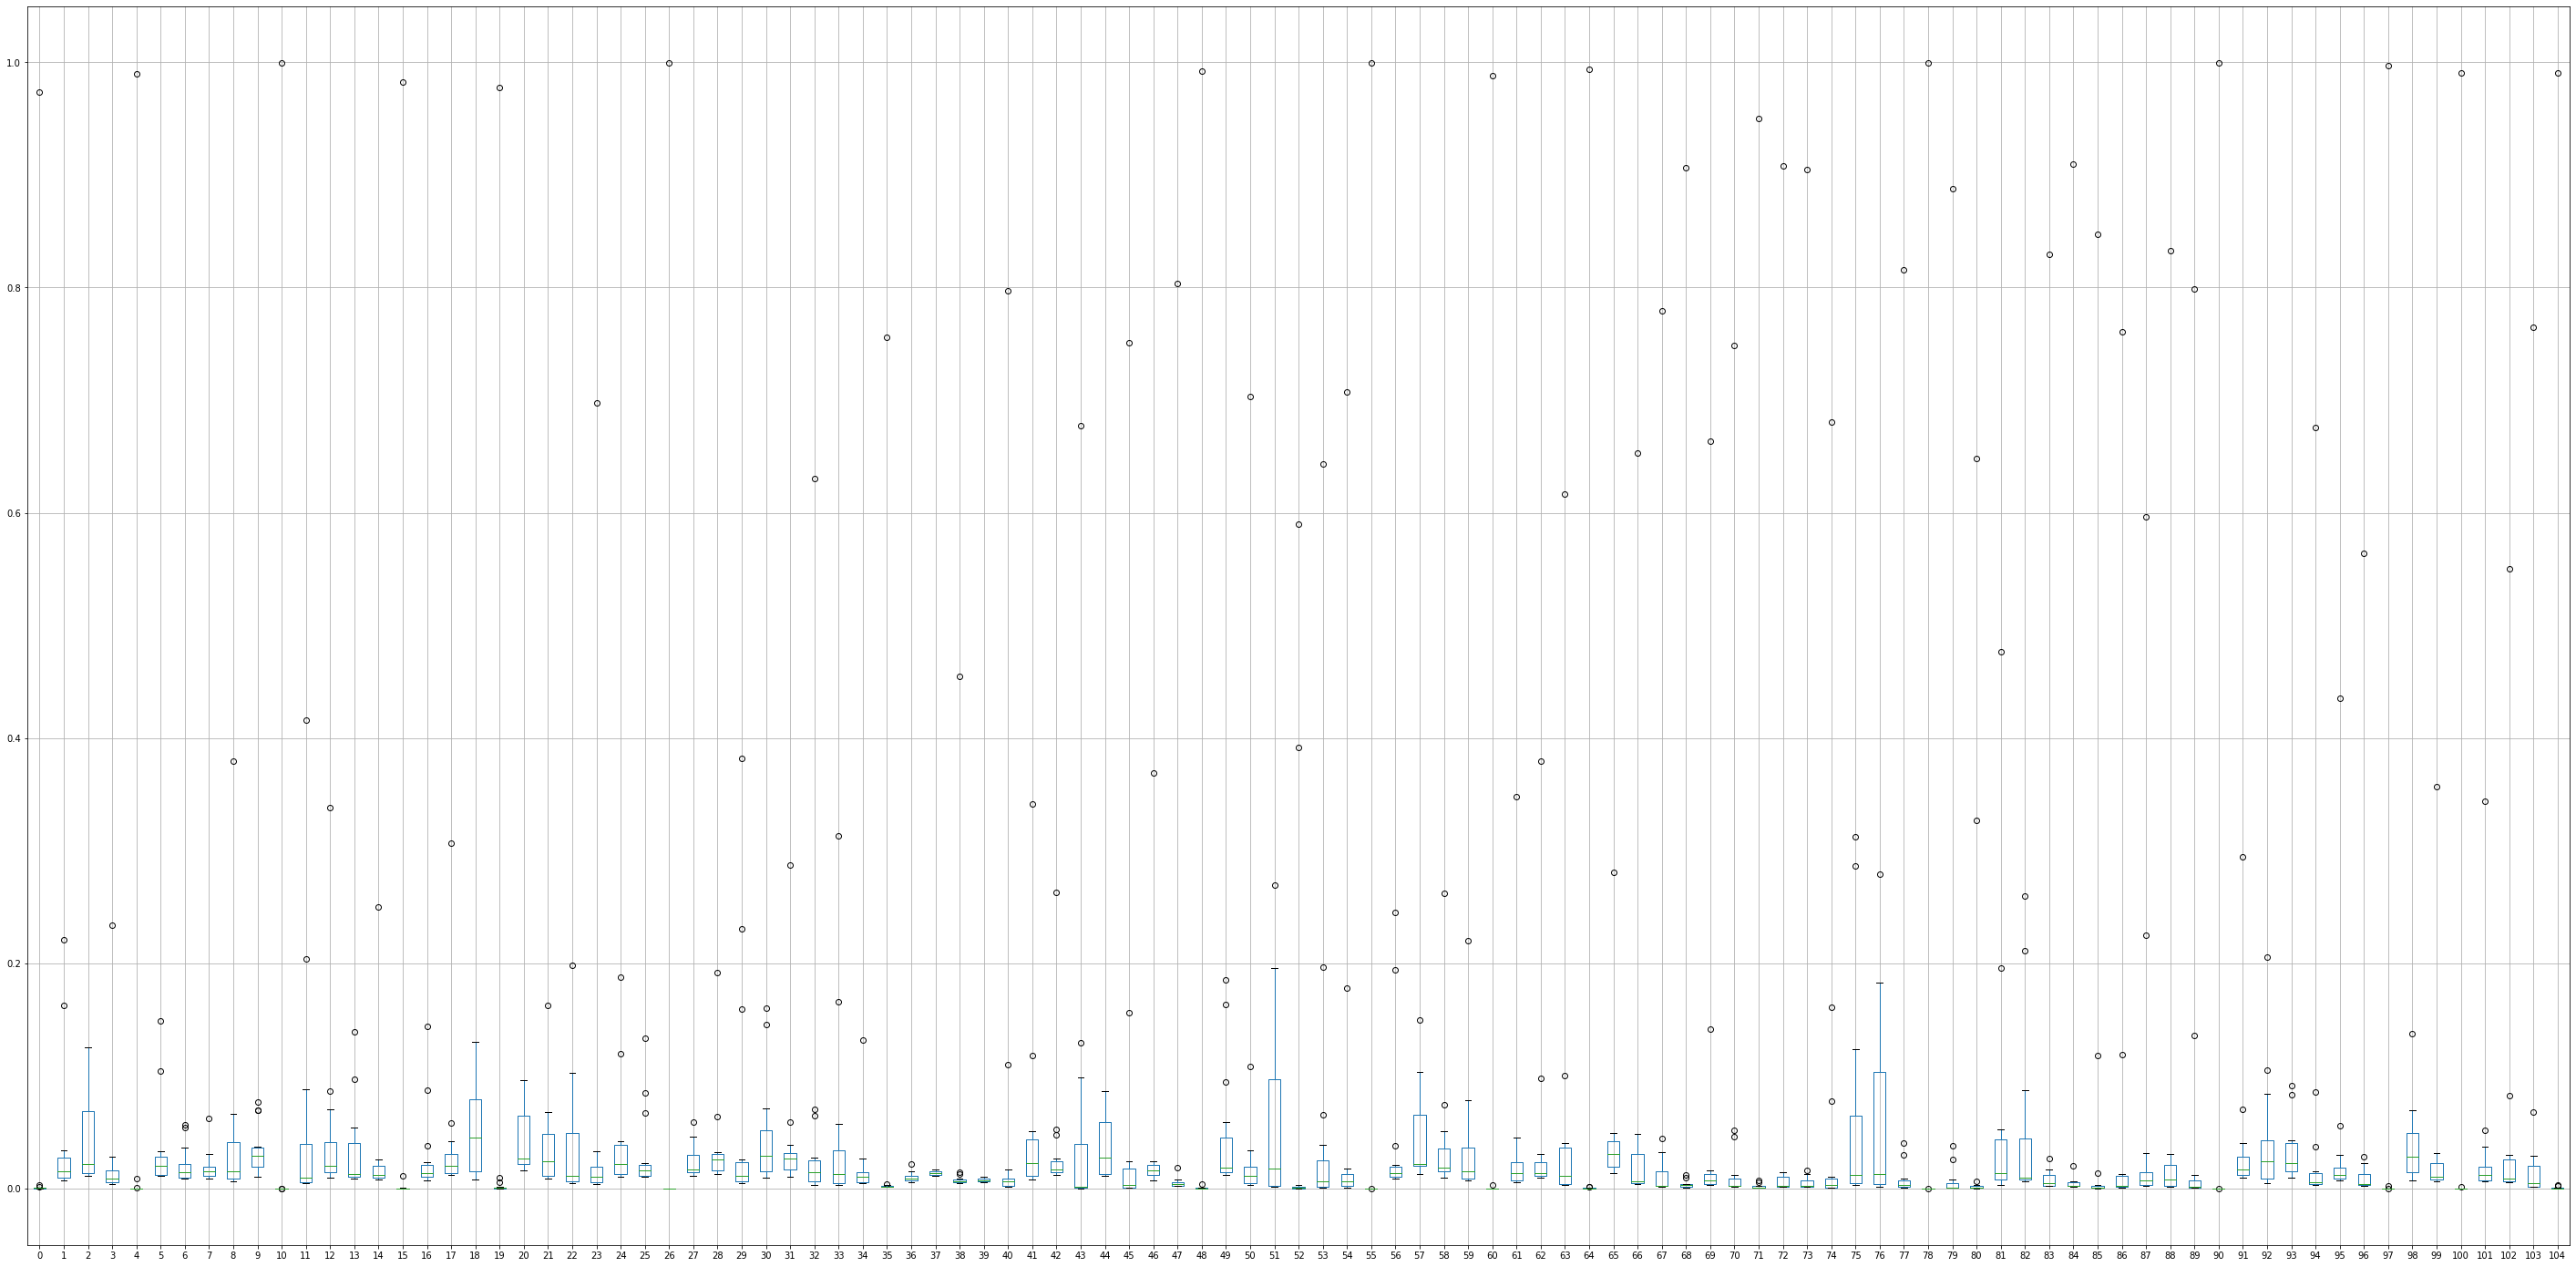

In [21]:
probsdf.T.boxplot()

In [22]:
# What does human generated text look like?